In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/CMC-CIST/classify_surgery/

/content/gdrive/MyDrive/CMC-CIST/classify_surgery


# Load data

* Data: dữ liệu các ca phẫu thuật
* Output: 1-hoàn thành, 0-không hoàn thành
* Input: 24 feature
>* File mô tả chi tiết dữ liệu trong Data folder


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_surgery = pd.read_csv('Data/Surgical-deepnet.csv')
df_surgery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14635 entries, 0 to 14634
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bmi                  14635 non-null  float64
 1   Age                  14635 non-null  float64
 2   asa_status           14635 non-null  int64  
 3   baseline_cancer      14635 non-null  int64  
 4   baseline_charlson    14635 non-null  int64  
 5   baseline_cvd         14635 non-null  int64  
 6   baseline_dementia    14635 non-null  int64  
 7   baseline_diabetes    14635 non-null  int64  
 8   baseline_digestive   14635 non-null  int64  
 9   baseline_osteoart    14635 non-null  int64  
 10  baseline_psych       14635 non-null  int64  
 11  baseline_pulmonary   14635 non-null  int64  
 12  ahrq_ccs             14635 non-null  int64  
 13  ccsComplicationRate  14635 non-null  float64
 14  ccsMort30Rate        14635 non-null  float64
 15  complication_rsi     14635 non-null 

# Preprocessing

## Check null
Không có feature nào chứa dữ liệu null

In [6]:
df_surgery.isnull().sum()

bmi                    0
Age                    0
asa_status             0
baseline_cancer        0
baseline_charlson      0
baseline_cvd           0
baseline_dementia      0
baseline_diabetes      0
baseline_digestive     0
baseline_osteoart      0
baseline_psych         0
baseline_pulmonary     0
ahrq_ccs               0
ccsComplicationRate    0
ccsMort30Rate          0
complication_rsi       0
dow                    0
gender                 0
hour                   0
month                  0
moonphase              0
mort30                 0
mortality_rsi          0
race                   0
complication           0
dtype: int64

## Remove duplicate

In [11]:
df_surgery = df_surgery.drop_duplicates()
print('Number of record:', df_surgery.shape[0])

Number of record: 11733


## Remove outlier

In [34]:
def boxplot(feature, df):
  fig = plt.figure(figsize=(5,3))
  sns.boxplot(x = feature, data=df)

def remove_outlier(data):
  values = []
  q1 = np.quantile(data, .25)
  q3 = np.quantile(data, .75)
  iqr = q3 - q1
  _min = q1 - 1.5*iqr
  _max = q3 + 1.5*iqr
  for i in list(data):
    if i < _min:
      i = _min
    elif i > _max:
      i = _max
    values.append(i)
  return values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

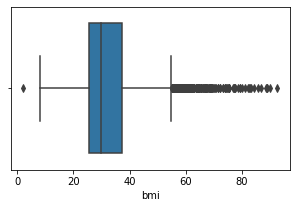

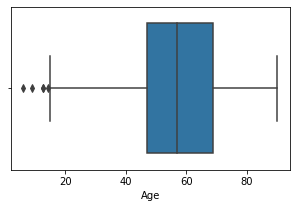

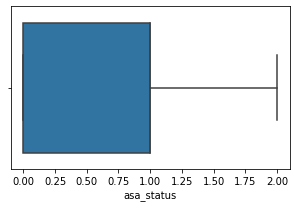

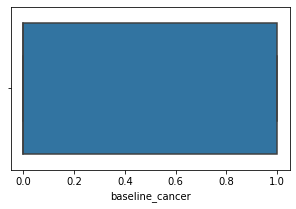

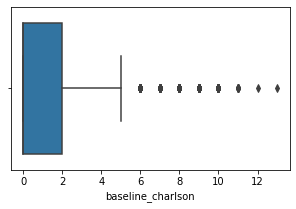

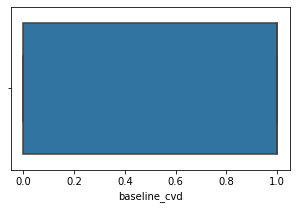

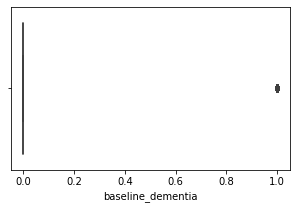

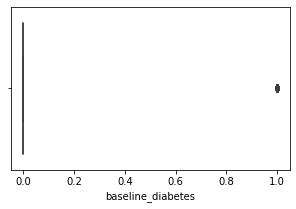

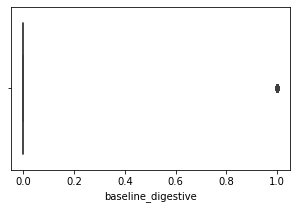

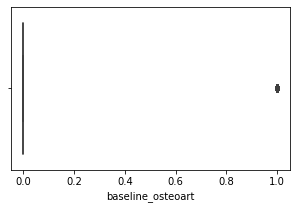

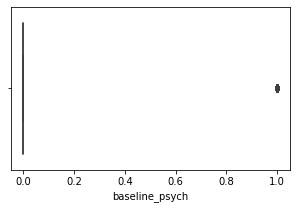

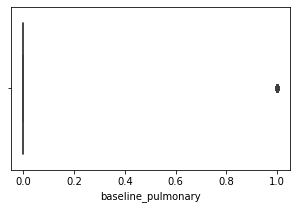

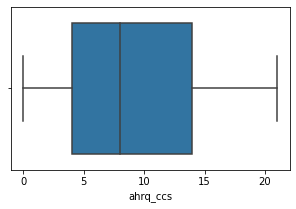

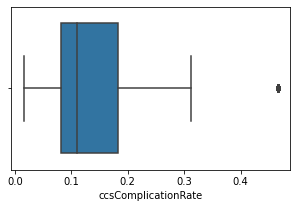

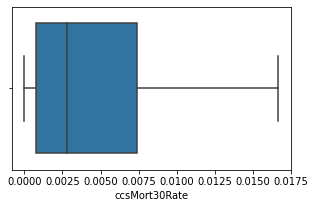

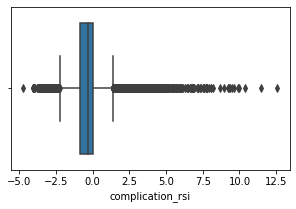

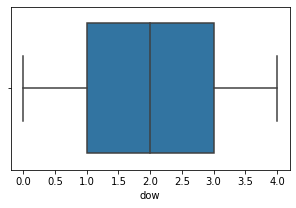

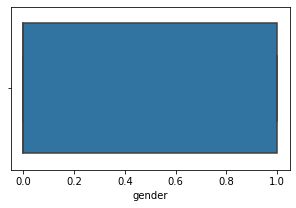

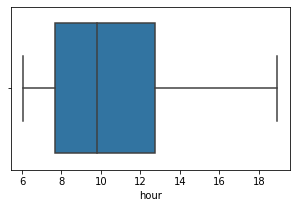

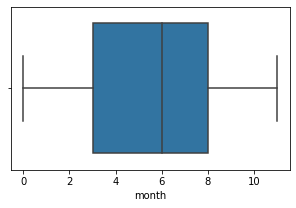

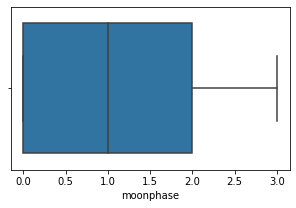

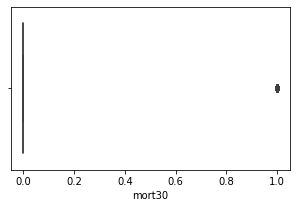

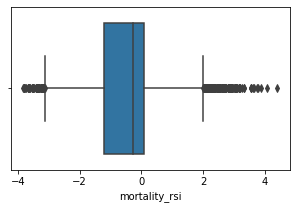

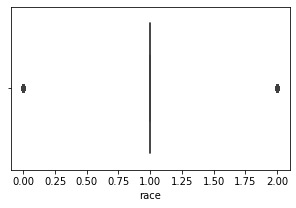

In [26]:
for feature in list(df_surgery.columns)[:-1]:
  boxplot(feature, df_surgery)

Các feature chứa nhiều outlier là: ['bmi', 'complication_rsi', 'Age', 'hour', 'ahrq_ccs', 'mortality_rsi', 'ccsComplicationRate', 'ccsMort30Rate']

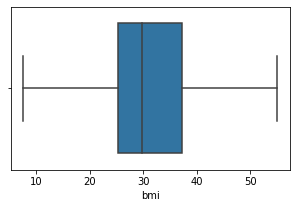

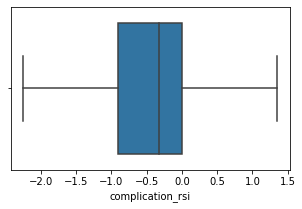

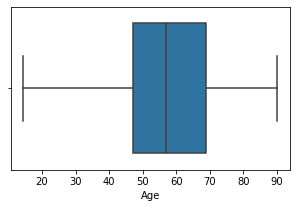

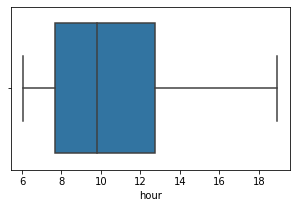

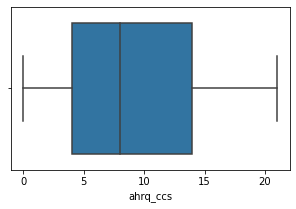

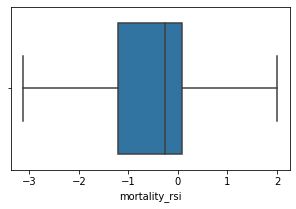

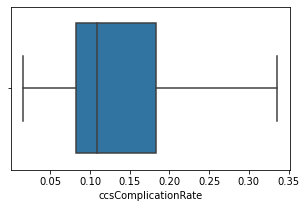

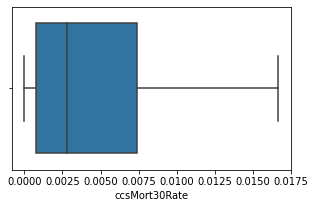

In [35]:
for feature in ['bmi', 'complication_rsi', 'Age', 'hour', 'ahrq_ccs', 'mortality_rsi', 'ccsComplicationRate', 'ccsMort30Rate']:
  df_surgery[feature] = remove_outlier(df_surgery[feature])
  boxplot(feature, df_surgery)

# Split data

Chia dữ liệu
> * Train: 1%
> * Test: 25%
> * Unlabeled: 73%

In [217]:
df_surgery = df_surgery.sample(frac=1)
df_surgery = df_surgery.reset_index(drop=True)

train_idx = round(len(df_surgery)*0.02)
test_idx = train_idx + round(len(df_surgery)*0.25)

train = df_surgery.iloc[:train_idx]
test = df_surgery.iloc[train_idx : test_idx]
unlabeled = df_surgery.iloc[test_idx:]

In [218]:
train['complication'].value_counts()

0    151
1     84
Name: complication, dtype: int64

In [232]:
test['complication'].value_counts()

0    2019
1     914
Name: complication, dtype: int64

In [229]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

X_unlabeled = unlabeled.iloc[:, :-1]

# Modeling
* Sử dụng thuật toán self-traing với classifer: logistics regression
* Idea: train classifier bằng tập train, dự đoán trên tập unlabeled để lấy ra các instance có most confidence rồi đẩy vào tập train để re-train classifer. Kết thúc khi unlabeled rỗng hoặc đạt giới hạn vòng lặp

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

## Self-training (LU  learning)

In [231]:
f1_trains, f1_tests, add_instances = [], [], []
iteration = 0

high_prob = [1]
while len(high_prob) > 0:
  # traing classififer 
  clf = LogisticRegression(max_iter=1000)
  clf.fit(X_train, y_train)

  # predict
  y_predict_train = clf.predict(X_train)
  y_predict_test = clf.predict(X_test)

  # evaluate
  print('Iteration:', iteration)
  f1_train = f1_score(y_train, y_predict_train)
  f1_trains.append(f1_train)
  f1_test = f1_score(y_test, y_predict_test)
  f1_tests.append(f1_test)
  print("Train f1_score:", f1_train)
  print('Tập test:')
  print(classification_report(y_test, y_predict_test))

  # predicting unlabeled
  pred_probs = clf.predict_proba(X_unlabeled)
  preds = clf.predict(X_unlabeled)
  prob_0 = pred_probs[:,0]
  prob_1 = pred_probs[:,1]
  
  confi_0 = np.max(prob_0) - 0.03
  confi_1 = np.max(prob_1) - 0.03
  if (confi_0 < .7) or (confi_1 < .7):
    break
 
  df_pred_prob = pd.DataFrame([])
  df_pred_prob['preds'] = preds
  df_pred_prob['prob_0'] = prob_0
  df_pred_prob['prob_1'] = prob_1
  df_pred_prob.index = X_unlabeled.index

  # Select most confidence 
  print('Label 0 confidence:', confi_0)
  print('Label 1 confidence:', confi_1)

  high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] >= confi_0],
                        df_pred_prob.loc[df_pred_prob['prob_1'] >= confi_1]],
                      axis=0)
  add_instances.append(high_prob)
  print('Number of most confidence add to train:', len(high_prob))

  # Add most confidence to train
  X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
  y_train = pd.concat([y_train, high_prob.preds])      
    
  # Remove most confidence from unlabeled
  X_unlabeled = X_unlabeled.drop(index=high_prob.index)
  print('Number of instance remaining unlabeled:', len(X_unlabeled))
  
  iteration = iteration + 1 

Iteration: 0
Train f1_score: 0.6344827586206897
Tập test:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      2019
           1       0.52      0.45      0.48       914

    accuracy                           0.70      2933
   macro avg       0.64      0.63      0.64      2933
weighted avg       0.69      0.70      0.69      2933

Label 0 confidence: 0.9664277006530135
Label 1 confidence: 0.9613797040122711
Number of most confidence add to train: 408
Number of instance remaining unlabeled: 8157
Iteration: 1
Train f1_score: 0.7888446215139442
Tập test:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2019
           1       0.52      0.46      0.49       914

    accuracy                           0.70      2933
   macro avg       0.64      0.63      0.64      2933
weighted avg       0.69      0.70      0.69      2933

Label 0 confidence: 0.9600553328802004
Label 1 confidence: 0.95

# Evaluate:
* Train tăng từ 63% -> 98%
* Test tăng 1%

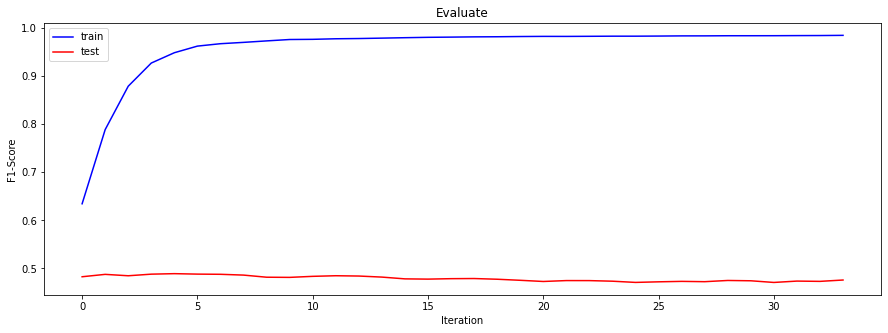

In [235]:
fig = plt.figure(figsize=(15,5))
plt.title('Evaluate')
plt.xlabel('Iteration')
plt.ylabel('F1-Score')
plt.plot(np.arange(len(f1_trains)), f1_trains, '-b', label='train')
plt.plot(np.arange(len(f1_tests)), f1_tests, '-r', label ='test')
plt.legend(loc='best')
plt.show()